Please run Evaluation_Fig_3_finetune.ipynb and Evaluation_Fig_3_kNN.ipynb

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

In [3]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils

/Users/yang.an/miniforge3/envs/mvTCR/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)

%load_ext autoreload
%autoreload 2

In [4]:
metadata = ['Tissue', 'Type', 'Tissue+Type', 'Sample', 'functional.cluster', 'clonotype', 'set', 'Cohort']

In [5]:
random_seed = 42
utils.fix_seeds(random_seed)

# UMAP Figures

In [6]:
holdout_cohorts = ['GSE154826',  # Lung with normal and tumor cells 18387 cells
                   'GSE162500']  # Lung with 18850 cells

mapper = {'GSE123814': 0, 'GSE114724': 1, 'GSE139555': 2, 'GSE145370': 3,
          'GSE180268': 4, 'GSE176021': 5, 'GSE148190': 6, 'GSE159251': 7,
          'CCR-20-4394': 8, 'PRJNA705464': 9, 'GSE121636': 10, 'GSE154826': 11, 'GSE162500': 12}

In [7]:
latent_with = sc.read_h5ad(f'../data/borcherding_moe_scarches.h5ad')
latent_without = sc.read_h5ad(f'../data/borcherding_moe_baseline.h5ad')

In [8]:
latent_with

AnnData object with n_obs × n_vars = 722461 × 50
    obs: 'batch', 'Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort', 'Cohort_held_out'
    uns: 'Cohort_colors', 'Cohort_held_out_colors', 'Tissue_colors', 'Type_colors', 'functional.cluster_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
latent_without

AnnData object with n_obs × n_vars = 722461 × 40
    obs: 'batch', 'Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort', 'Cohort_held_out'
    uns: 'Cohort_colors', 'Cohort_held_out_colors', 'Tissue_colors', 'Type_colors', 'functional.cluster_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)

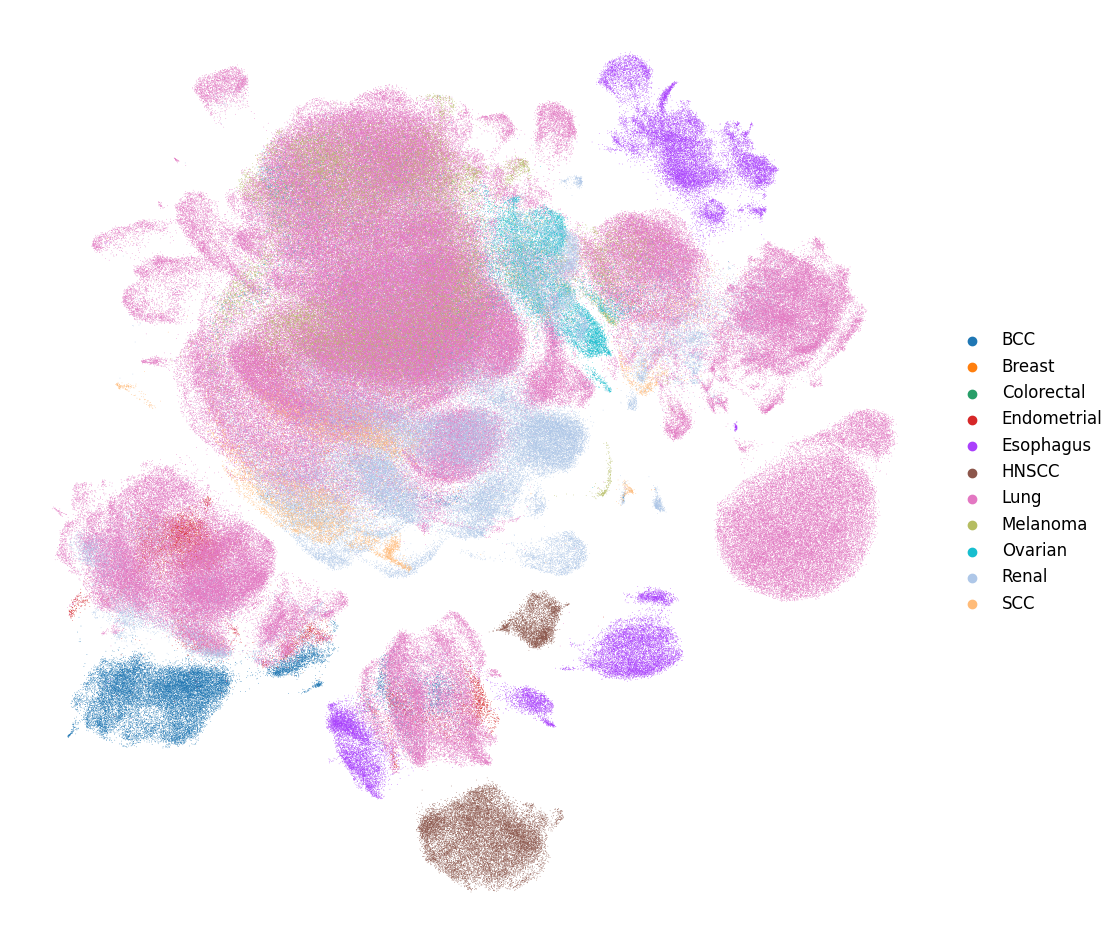

In [11]:
sc.pl.umap(latent_with, color='Tissue', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Cancer.png')

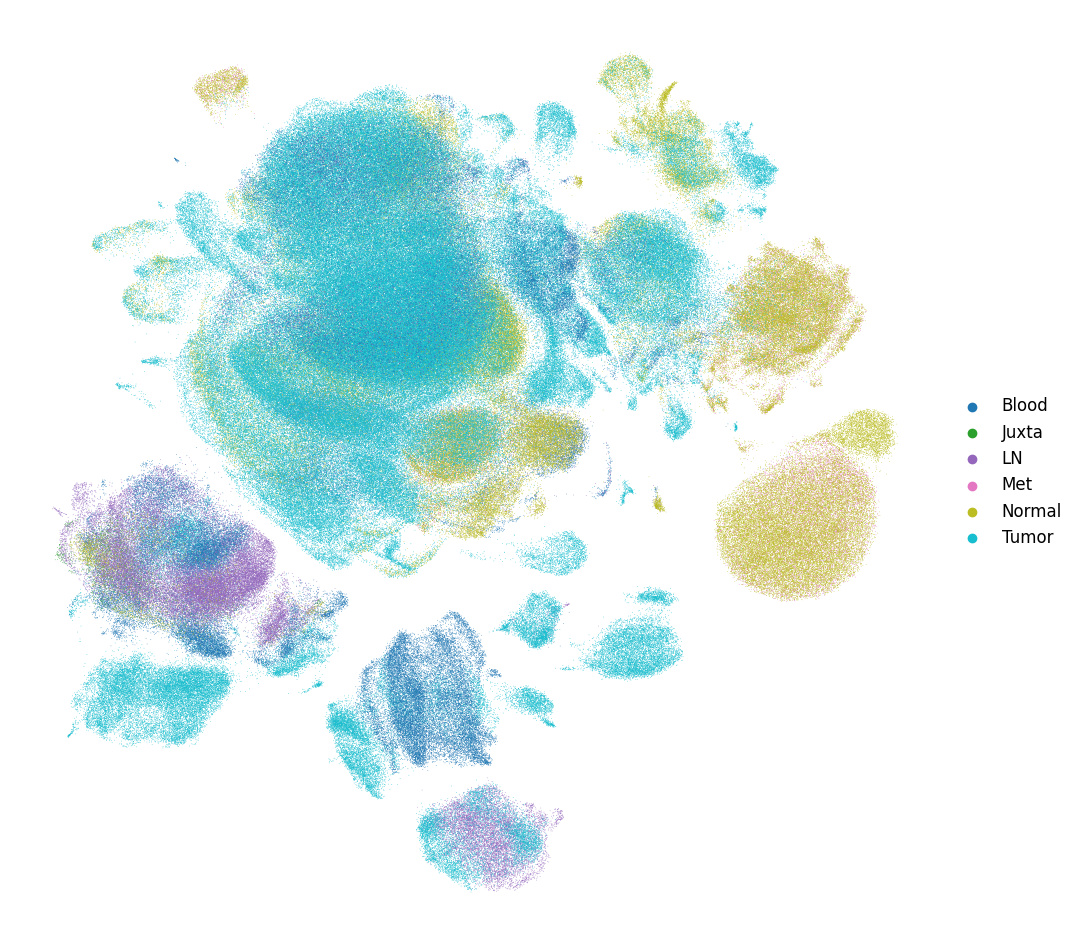

In [12]:
sc.pl.umap(latent_with, color='Type', size=1, palette='tab10', title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Origin.png')

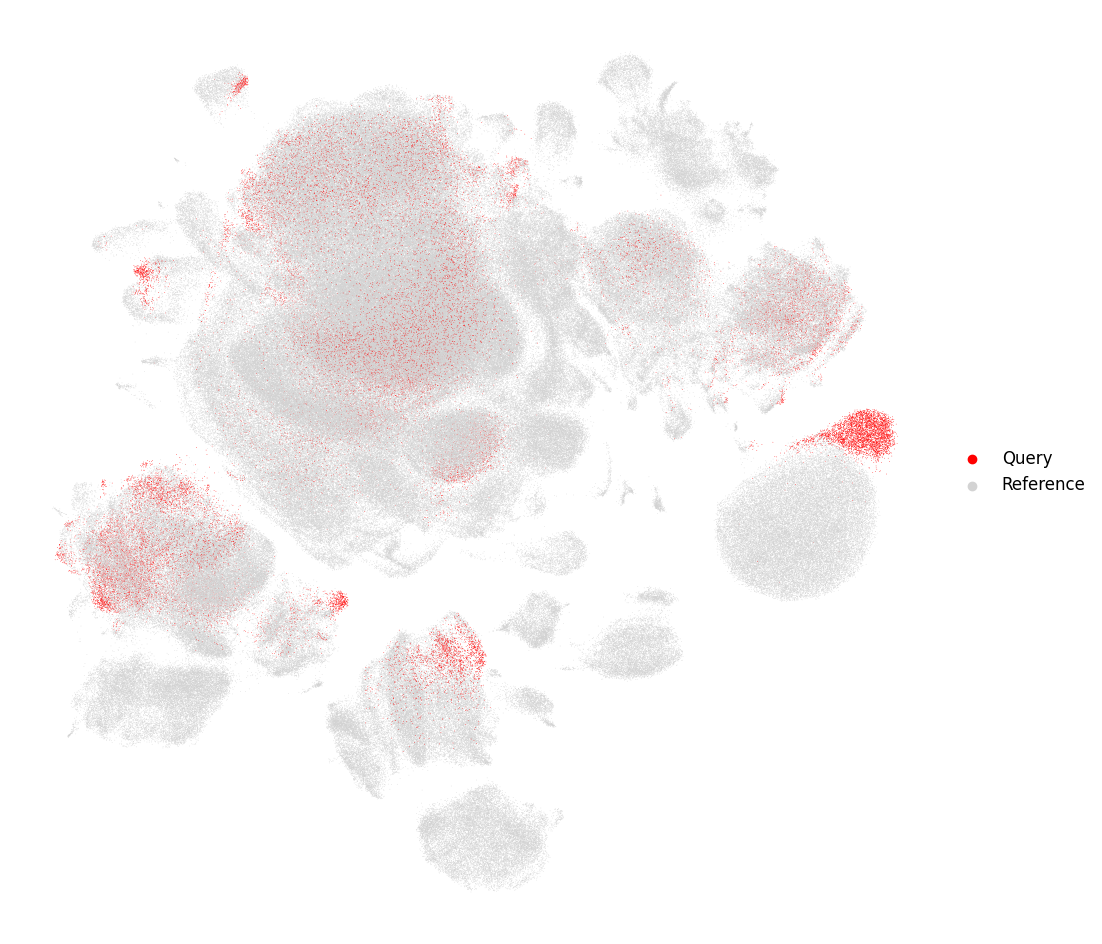

In [13]:
latent_with.uns['Cohort_held_out_colors'] = np.array(['red', 'lightgrey'], dtype=object)
latent_with.obs['Cohort_held_out'] = '.'
latent_with.obs.loc[~latent_with.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Reference'
latent_with.obs.loc[latent_with.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Query'
sc.pl.umap(latent_with, color='Cohort_held_out', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Source.png')

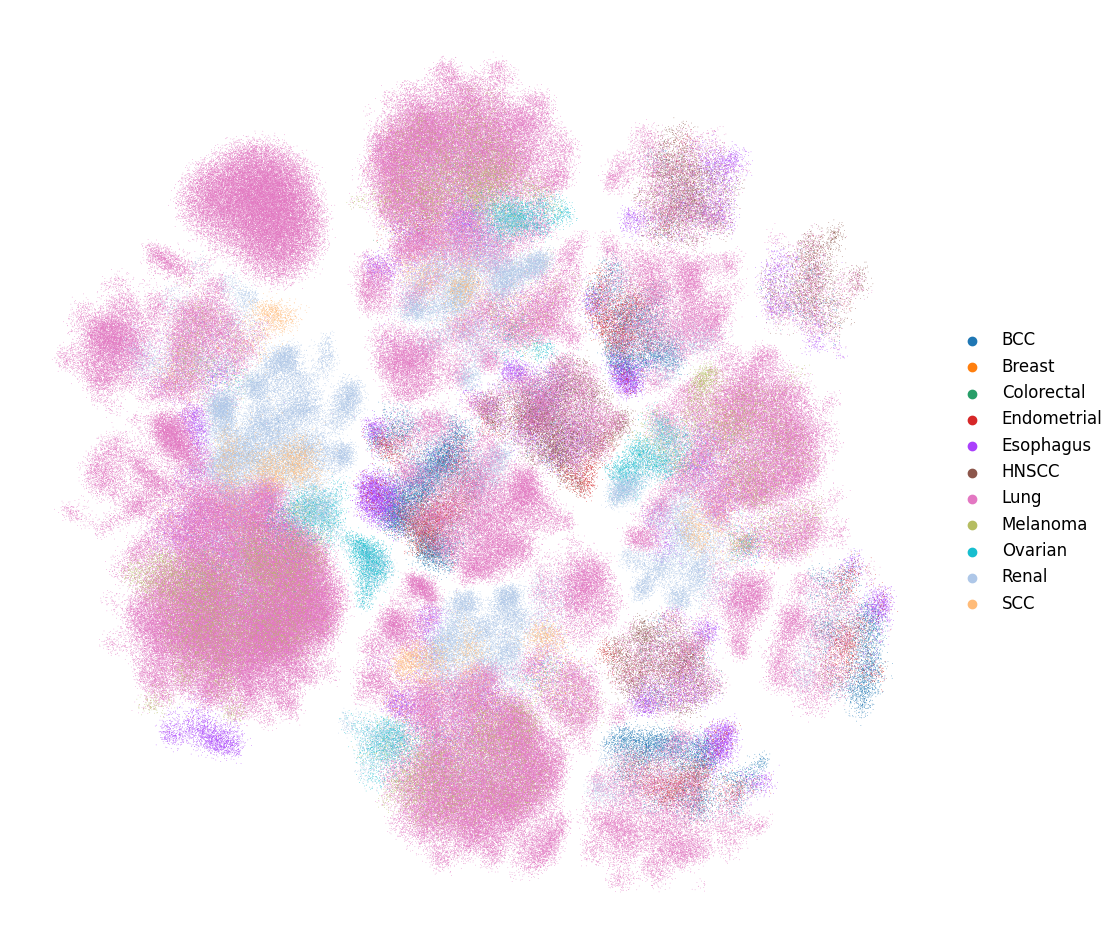

In [14]:
sc.pl.umap(latent_without, color='Tissue', size=1, ncols=2, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Cancer_wo.png')

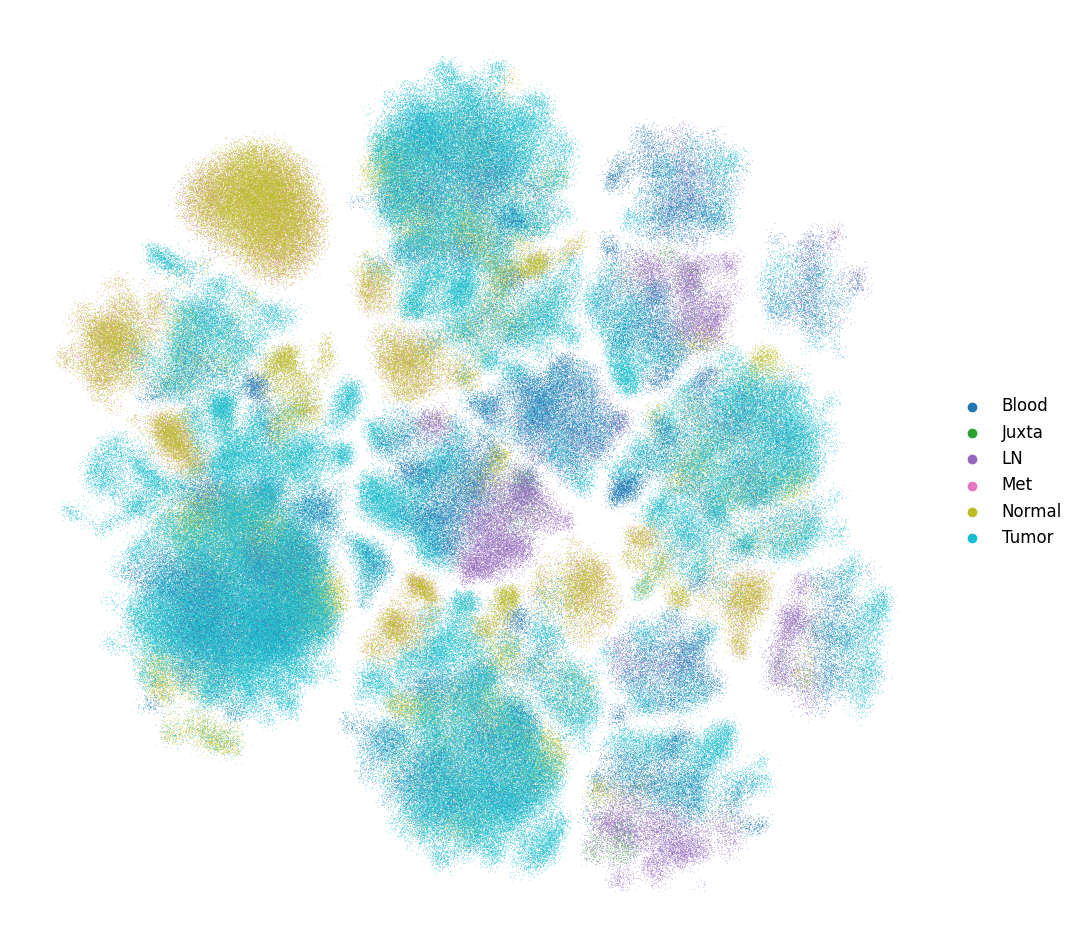

In [15]:
sc.pl.umap(latent_without, color='Type', size=1, palette='tab10', title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Origin_wo.png')

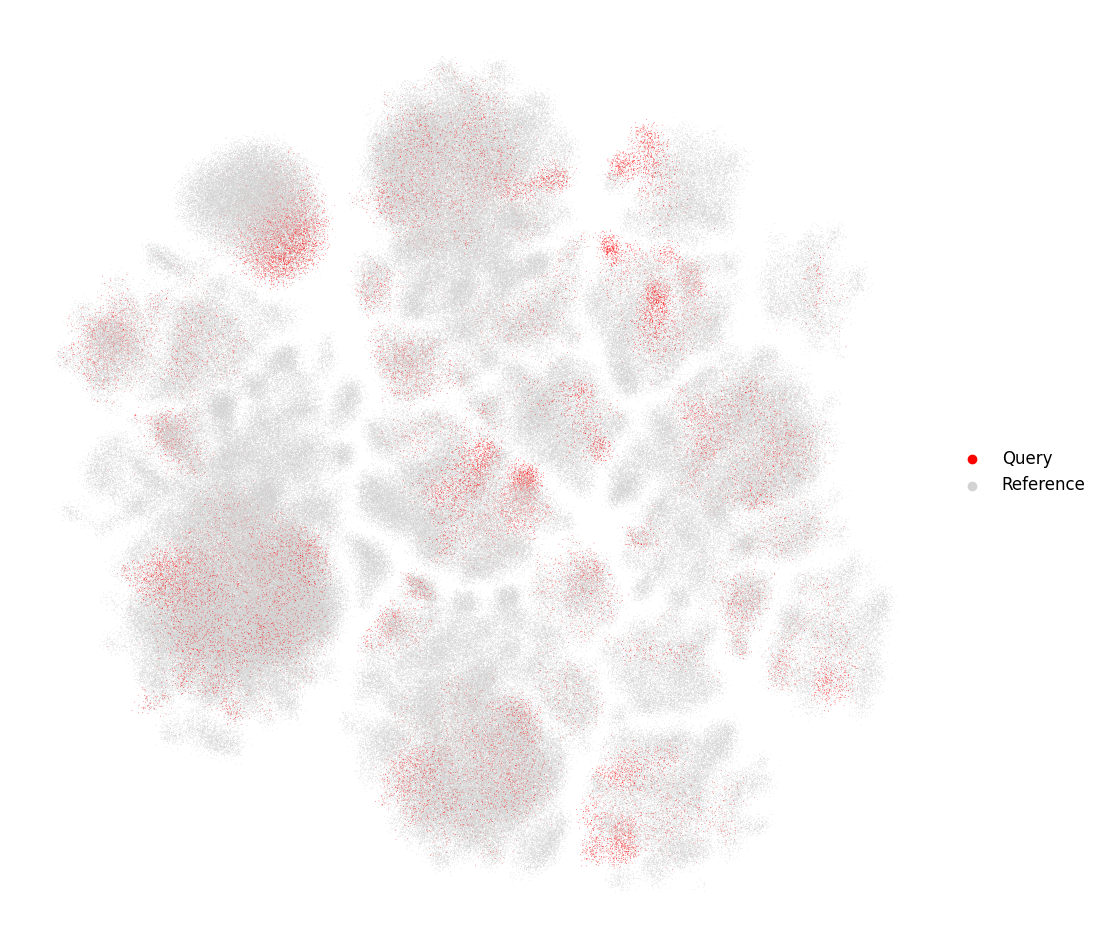

In [16]:
latent_without.uns['Cohort_held_out_colors'] = np.array(['red', 'lightgrey'], dtype=object)
latent_without.obs['Cohort_held_out'] = '.'
latent_without.obs.loc[~latent_without.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Reference'
latent_without.obs.loc[latent_without.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Query'
sc.pl.umap(latent_without, color='Cohort_held_out', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Source_wo.png')

# kNN Scores

In [12]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12, title_fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title
sns.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sns.set_palette('colorblind')
set_font_size(18)

In [13]:
df = pd.read_csv('../results/kNN.csv')
df['Label'] = df['Label'].map({'Tissue': 'Cancer', 'Type': 'Tissue', 'functional.cluster': 'Cell Type'})
df['Method'] = df['Method'].map({'MoE w/ scArches': 'mvTCR + scArches', 'MoE w/o scArches': 'mvTCR (unconditional)'})

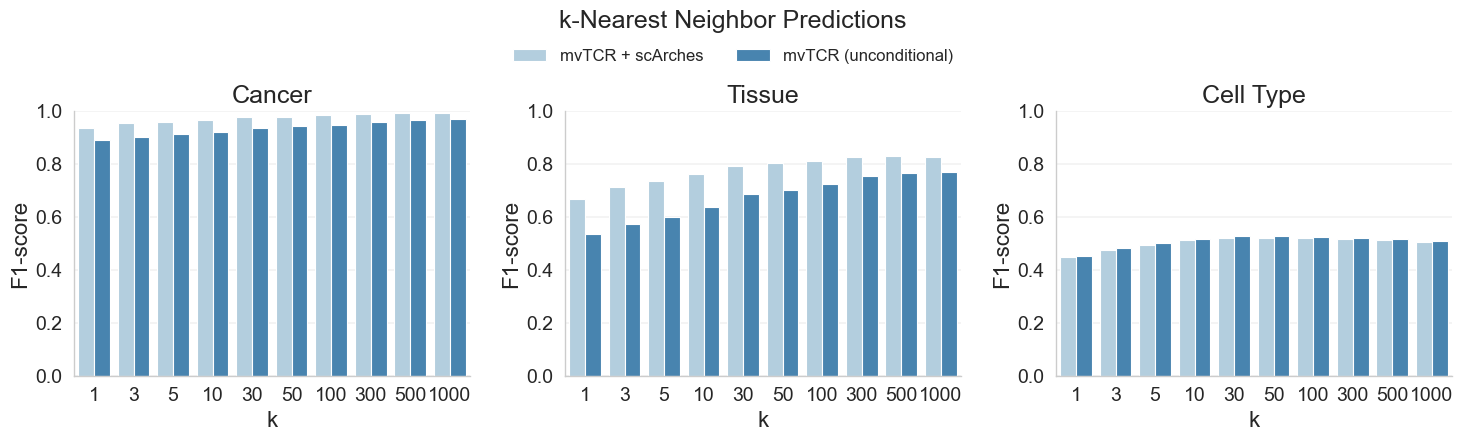

In [14]:
plt.figure(figsize=(15, 4))
for i, label in enumerate(['Cancer', 'Tissue', 'Cell Type']):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(df[df['Label'] == label], hue='Method', y='Value', x='k', palette='Blues')
    plt.legend([], [], frameon=False)
    plt.ylabel('F1-score')
    plt.title(label)
    plt.ylim([0, 1])
    ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.06), frameon=False)
plt.tight_layout()
plt.suptitle('k-Nearest Neighbor Predictions', y=1.12)
plt.savefig('../figures/kNN_barplot.png', bbox_inches='tight')
plt.show()

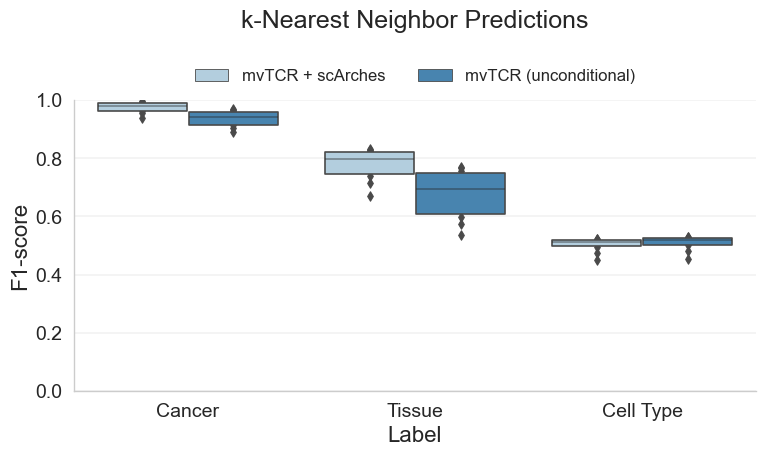

In [16]:
sns.catplot(df, hue='Method', y='Value', x='Label', kind='boxen', legend_out=False, palette='Blues', height=4, aspect=2)
plt.title('k-Nearest Neighbor Predictions', y=1.22)
plt.legend(loc='upper center', frameon=False, ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.savefig('../figures/kNN_boxenplot.png', bbox_inches='tight')
plt.show()

# Scale Plot

In [17]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title
sns.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sns.set_palette('colorblind')
set_font_size(18)

In [24]:
df_mvtcr = pd.read_csv('../results/scale_plot_mvtcr.csv', index_col=0)
df_conga = pd.read_csv('../results/scale_plot_conga.csv', index_col=0)
df_tessa = pd.read_csv('../results/scale_plot_tessa.csv', index_col=0)

In [25]:
df_mvtcr

num_samples         time
0          300    14.034776
1         1000    16.342088
2         3000    27.267607
3        10000    58.643500
4        30000   165.558368
5       100000   544.950237
6       300000  1772.720954
7       722461  4791.180278

In [26]:
df_conga

num_samples          time
0          300     43.704534
1         1000    100.961826
2         3000    377.710788
3        10000   1527.247334
4        30000   7593.094902
5       100000  73516.793039

In [27]:
df_tessa

num_samples           time
0          300     468.117998
1         1000    2857.621913
2         3000   10413.803009
3        10000   54196.988069
4        30000  389578.448223

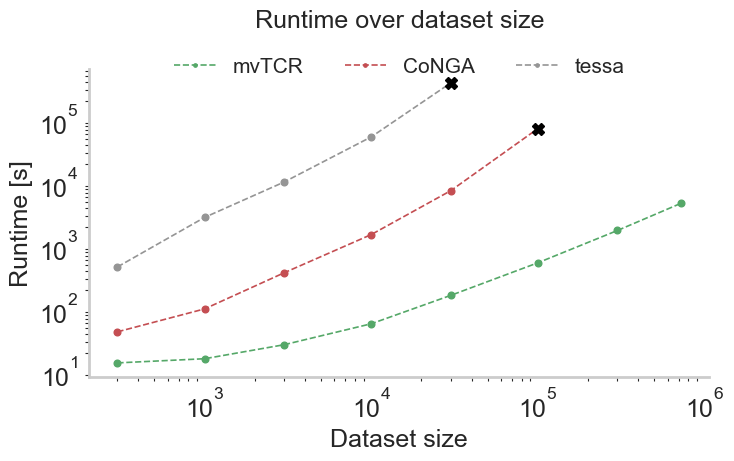

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(df_mvtcr['num_samples'], df_mvtcr['time'], 'o--', label='mvTCR', color=sns.color_palette('deep')[2])
plt.plot(df_conga['num_samples'], df_conga['time'], 'o--', label='CoNGA', color=sns.color_palette('deep')[3])
plt.plot(df_tessa['num_samples'], df_tessa['time'], 'o--', label='tessa', color=sns.color_palette('Greys', n_colors=5)[2])

plt.plot(df_conga['num_samples'].iloc[-1], df_conga['time'].iloc[-1], 'X', color='black', ms=8)
plt.plot(df_tessa['num_samples'].iloc[-1], df_tessa['time'].iloc[-1], 'X', color='black', ms=8)

plt.xscale('log')
plt.yscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

pos = (0.5, 0.9)
handles, labels = ax.get_legend_handles_labels()
label_dict = dict(zip(labels, handles))
order = ['mvTCR', 'CoNGA', 'tessa']

ax.legend([label_dict[o] for o in order], order,
          markerscale=0.5, fontsize='small', loc='upper center', frameon=False,
          bbox_to_anchor=(0.5, 1.1), ncol=3,
          bbox_transform=ax.transAxes)

#plt.legend(['mvTCR', 'CoNGA', 'tessa'])
plt.ylabel('Runtime [s]')
plt.xlabel('Dataset size')
#plt.ylim(1e1, 1e6)
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
plt.title('Runtime over dataset size', weight='normal', pad=30)
plt.savefig(f'../figures/03_scale_plot.svg',bbox_inches='tight')